# Word2vec - Word Embeddings

In [2]:
!pip install adjustText --quiet

In [3]:
import zipfile
import re
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from adjustText import adjust_text

## **Understanding the data**
## Downloading the data

In [4]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'

def download_data(url, data_dir):
  """Download a file if not present, and make sure it's the right size."""

  os.makedirs(data_dir, exist_ok=True)

  file_path = os.path.join(data_dir, 'bbc-fulltext.zip')

  if not os.path.exists(file_path):
    print('Downloading file...')
    filename, _ = urlretrieve(url, file_path)
  else:
    print("File already exists")

  extract_path = os.path.join(data_dir, 'bbc')

  if not os.path.exists(extract_path):
    with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
      zipf.extractall(data_dir)
  else:
    print("bbc-fulltext.zip has already been extracted")


download_data(url, 'data')

## Read Data without Preprocessing

Reads data as it is to a string and tokenize it using spaces and returns a list of words


In [5]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []
    
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'README' in f:
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as f:
                
                story = []
                # Read all the lines
                for row in f:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories
                
  
news_stories = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## **Build a Tokenizer**

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Exploring the tokenizer

In [7]:
n_vocab = len(tokenizer.word_index.items()) + 1
print(f"Vocabulary size: {n_vocab}")

print("\nWords at the top")
print('\t', dict(list(tokenizer.word_index.items())[:10]))
print("\nWords at the bottom")
print('\t', dict(list(tokenizer.word_index.items())[-10:]))

Vocabulary size: 32360

Words at the top
	 {'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5, 'in': 6, 'for': 7, 'is': 8, 'that': 9, 'on': 10}

Words at the bottom
	 {'shefrin': 32350, 'holly': 32351, 'frankin': 32352, 'bloopers': 32353, "tabloids'": 32354, 'scrapbook': 32355, 'souvenir': 32356, 'stepdaughter': 32357, 'ass': 32358, 'saver': 32359}


## Build a Tokenizer (Refined)

Here, we will restrict the vocabulary to 15000 and eleminate words except the first most common 15000 words


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer


n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab-1,
    lower=True,
    split=' ',
    oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Checking the results of the tokenizer

In [12]:
print(f"Original: {news_stories[0][:100]}")
print(f"Sequence IDs: {tokenizer.texts_to_sequences([news_stories[0][:100]])[0]}")

Original: Real will finish abandoned match  Real Madrid and Real Socieded will play the final six minutes of t
Sequence IDs: [286, 23, 1881, 4501, 328, 286, 1076, 5, 286, 1, 23, 153, 2, 253, 191, 495, 4, 1360]


**Converting all articles to word ID sequences**

In [13]:
news_sequences = tokenizer.texts_to_sequences(news_stories)

## **Generating skip-grams from the corpus**

In TensorFlow you have the convenient `tf.keras.preprocessing.sequence.skipgrams()` function to generate skipgrams.


In [17]:
news_sequences[0][:5]

[286, 23, 1881, 4501, 328]

In [18]:
sample_word_ids = news_sequences[0][:5]
sample_phrase = ' '.join([tokenizer.index_word[wid] for wid in sample_word_ids])
print(f"Sample phrase: {sample_phrase}")
print(f"Sample word IDs: {sample_word_ids}\n")

window_size = 1 # How many words to consider left and right.

inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    sample_word_ids, 
    vocabulary_size=n_vocab, 
    window_size=window_size, negative_samples=1.0, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)


print("Sample skip-grams")

for inp, lbl in zip(inputs, labels):
    print(f"\tInput: {inp} ({[tokenizer.index_word[wi] for wi in inp]}) / Label: {lbl}")

Sample phrase: real will finish abandoned match
Sample word IDs: [286, 23, 1881, 4501, 328]

Sample skip-grams
	Input: [286, 23] (['real', 'will']) / Label: 1
	Input: [23, 286] (['will', 'real']) / Label: 1
	Input: [23, 1881] (['will', 'finish']) / Label: 1
	Input: [1881, 23] (['finish', 'will']) / Label: 1
	Input: [1881, 4501] (['finish', 'abandoned']) / Label: 1
	Input: [4501, 1881] (['abandoned', 'finish']) / Label: 1
	Input: [4501, 328] (['abandoned', 'match']) / Label: 1
	Input: [328, 4501] (['match', 'abandoned']) / Label: 1
	Input: [4501, 13729] (['abandoned', "cameroon's"]) / Label: 0
	Input: [1881, 5840] (['finish', 'housewives']) / Label: 0
	Input: [23, 7357] (['will', 'advances']) / Label: 0
	Input: [1881, 13328] (['finish', 'barnes']) / Label: 0
	Input: [328, 6533] (['match', 'betamax']) / Label: 0
	Input: [286, 6115] (['real', 'sells']) / Label: 0
	Input: [4501, 9146] (['abandoned', 'ginepri']) / Label: 0
	Input: [23, 11943] (['will', 'discovering']) / Label: 0



## Generating negative candidates

Word2vec algorithms rely on negative candidates to understand words that do not appear in the context of a given target word.


In [19]:
inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    sample_word_ids, 
    vocabulary_size=len(tokenizer.word_index.items())+1, 
    window_size=window_size, negative_samples=0, shuffle=False,    
)

inputs, labels = np.array(inputs), np.array(labels)

negative_sampling_candidates, true_expected_count, sampled_expected_count = tf.random.log_uniform_candidate_sampler(
    # A true context word that appears in the context of the target
    true_classes=inputs[:1,1:], # [b, 1] sized tensor
    num_true=1, # number of true words per example
    num_sampled=10,
    unique=True,
    range_max=n_vocab,            
    name="negative_sampling"
)

print(f"Positive sample: {inputs[:1,1:]}")
print(f"Negative samples: {negative_sampling_candidates}")
print(f"true_expected_count: {true_expected_count}")
print(f"sampled_expected_count: {sampled_expected_count}")

Positive sample: [[23]]
Negative samples: [  44  832  819  226    1   32    9 2025   23    0]
true_expected_count: [[0.04571897]]
sampled_expected_count: [0.02485704 0.00137159 0.00139331 0.00501681 0.37742305 0.03362463
 0.1037828  0.00056434 0.04571897 0.5608634 ]


**`Using tf.nn.sampled_softmax_loss()`**

In [20]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(n_vocab, sampling_factor=1e-05)

print(sampling_table)

[0.00315225 0.00315225 0.00547597 ... 1.         1.         1.        ]


## Generating data (positive + negative candidates)

In [21]:
def skip_gram_data_generator(sequences, window_size, batch_size, negative_samples, vocab_size, seed=None):
    
    rand_sequence_ids = np.arange(len(sequences))                    
    np.random.shuffle(rand_sequence_ids)


    for si in rand_sequence_ids:
        
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequences[si], 
            vocabulary_size=vocab_size, 
            window_size=window_size, 
            negative_samples=0.0, 
            shuffle=False,
            sampling_table=sampling_table,
            seed=seed
        )
        
        targets, contexts, labels = [], [], []
        
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=negative_samples,
              unique=True,
              range_max=vocab_size,              
              name="negative_sampling")

            # Build context and label vectors (for one target word)
            context = tf.concat(
                [tf.constant([context_word], dtype='int64'), negative_sampling_candidates],
                axis=0
            )
            
            label = tf.constant([1] + [0]*negative_samples, dtype="int64")

            # Append each element from the training example to global lists.
            targets.extend([target_word]*(negative_samples+1))
            contexts.append(context)
            labels.append(label)

        contexts, targets, labels = np.concatenate(contexts), np.array(targets), np.concatenate(labels)
        
        assert contexts.shape[0] == targets.shape[0]
        assert contexts.shape[0] == labels.shape[0]
        
        # If seed is not provided generate a random one
        if not seed:
            seed = random.randint(0, 10e6)
            
        np.random.seed(seed)
        np.random.shuffle(contexts)
        np.random.seed(seed)
        np.random.shuffle(targets)
        np.random.seed(seed)
        np.random.shuffle(labels)
        
    
        for eg_id_start in range(0, contexts.shape[0], batch_size):            
            yield (
                targets[eg_id_start: min(eg_id_start+batch_size, targets.shape[0])], 
                contexts[eg_id_start: min(eg_id_start+batch_size, contexts.shape[0])]
            ), labels[eg_id_start: min(eg_id_start+batch_size, labels.shape[0])]


news_skip_gram_gen = skip_gram_data_generator(
    news_sequences, 4, 10, 5, n_vocab
)

for btc, bl in news_skip_gram_gen:
    
    print(btc)
    print(bl)
    
    break

(array([12058, 12058,    54,    54,   242,  3124,  4353,  3272,  1839,
         249]), array([   1,  130,  188,  461, 1046,   42,   69,    0,  313, 1522]))
[0 0 0 1 0 0 0 0 0 0]



# Skip-Gram Algorithm
## Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).


In [22]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of n on either side of target word
negative_samples = 4 # Number of negative samples generated per example

epochs = 5 # Number of epochs to train for

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)

# Defining the Model

Here we will define the skip-gram model. It contains two embedding layers; context and target embeddings. The final output is computed as the dot product between the corresponding lookups from the context and target embeddings for a given batch of context and target words.


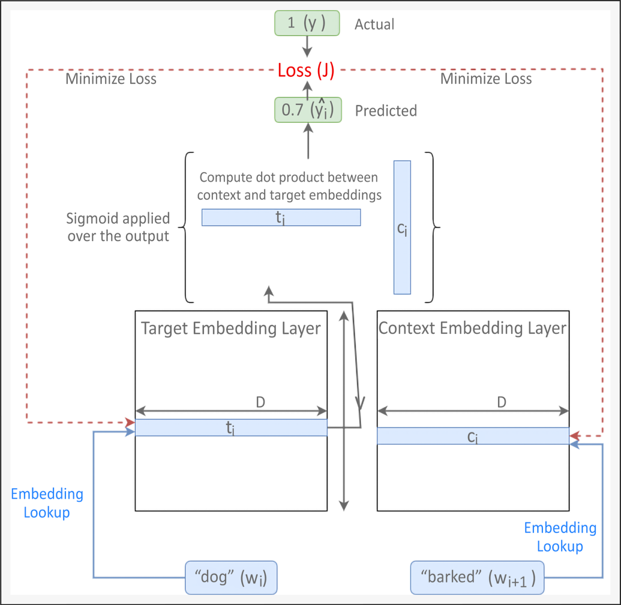

In [23]:
import tensorflow.keras.backend as K

K.clear_session()

# Inputs - skipgrams() function outputs target, context in that order
# we will use the same order
input_1 = tf.keras.layers.Input(shape=(), name='target')
input_2 = tf.keras.layers.Input(shape=(), name='context')

# Two embeddings layers are used one for the context and one for the target
context_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='context_embedding'
)
target_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='target_embedding'
)

# Lookup outputs of the embedding layers
target_out = target_embedding_layer(input_1)
context_out = context_embedding_layer(input_2)

# Computing the dot product between the two 
out = tf.keras.layers.Dot(axes=-1)([context_out, target_out])

# Defining the model
skip_gram_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=out, name='skip_gram_model')

# Compiling the model
skip_gram_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam'
)

skip_gram_model.summary()

Model: "skip_gram_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 context (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 target (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 context_embedding (Embedding)  (None, 128)          1920128     ['context[0][0]']                
                                                                                                  
 target_embedding (Embedding)   (None, 128)          1920128     ['target[0][0]']                 
                                                                                    


## Calculating Word Similarities

We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below. Furthermore, we define the computations as a callback, which will automatically run at the end of an epoch during model training.


In [24]:
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_term_ids, model_with_embeddings, tokenizer):
        
        self.valid_term_ids = valid_term_ids
        self.model_with_embeddings = model_with_embeddings
        self.tokenizer = tokenizer
        
        super().__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        """ Validation logic """
                
        # We will use context embeddings to get the most similar words
        # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
        embedding_weights = self.model_with_embeddings.get_layer("context_embedding").get_weights()[0]
        normalized_embeddings = embedding_weights / np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))
        
        # Get the embeddings corresponding to valid_term_ids
        valid_embeddings = normalized_embeddings[self.valid_term_ids, :]
        
        # Compute the similarity between valid_term_ids and all the embeddings
        # V x d (d x D) => V x D
        top_k = 5 # Top k items will be displayed
        similarity = np.dot(valid_embeddings, normalized_embeddings.T)
        
        # Invert similarity matrix to negative
        # Ignore the first one because that would be the same word as the probe word
        similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]
                
        # Print the output
        for i, term_id in enumerate(valid_term_ids):
            
            similar_word_str = ', '.join([self.tokenizer.index_word[j] for j in similarity_top_k[i, :] if j >= 1])
            print(f"{self.tokenizer.index_word[term_id]}: {similar_word_str}")
        
        print('\n')

### Running the Skip-Gram Algorithm

In [25]:
skipgram_validation_callback = ValidationCallback(valid_term_ids, skip_gram_model, tokenizer)

for ei in range(epochs):
    
    print(f"Epoch: {ei+1}/{epochs} started")
    
    news_skip_gram_gen = skip_gram_data_generator(
        news_sequences, window_size, batch_size, negative_samples, n_vocab
    )
    
    skip_gram_model.fit(
        news_skip_gram_gen, epochs=1, 
        callbacks=skipgram_validation_callback,        
    )

Epoch: 1/5 started
   2233/Unknown - 163s 73ms/step - loss: 0.5734election: focus, 1999, move, government
me: lot, how, government, move
with: between, against, or, from, 14
you: people, we, them, able, can
were: do, think, connectors, important, thousands
win: end, going, trying, way
those: end, allowed, trying, amount
music: way, allowed, trying, end
also: never, really, taken, done, now
international: grandchildren, seen, value, technological
best: 2005, break, way, move
him: trying, made, help, amount
too: do, going, made, make
some: keen, move, seen, way
through: lack, save, reason, used
mr: tony, michael, argued, seems, harm
unit: club, due, relationship, come, bluetooth
concern: issue, links, allow, way
bush: decade, fagin, pin, hands, examined
fear: made, do, need, appears
reached: person, part, tools, generate, government
risk: trying, end, way, course
sound: called, move, technological, 2005
previously: children, you, we, taken, 1983
campbell: try, rome, distributed, forum
pr

# The Continuous Bag-of-Words (CBOW) algorithm

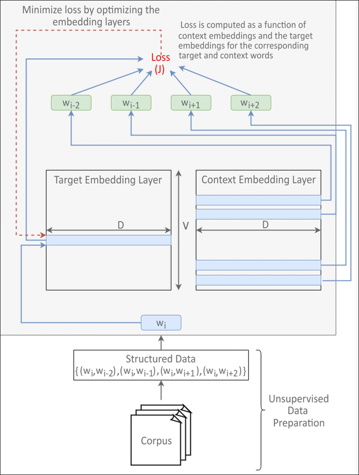

In [26]:
def cbow_grams(sequence, vocabulary_size,
              window_size=4, negative_samples=1., shuffle=True,
              categorical=False, sampling_table=None, seed=None):
    
    targets, contexts, labels = [], [], []    
        
    for i, wi in enumerate(sequence):
        
        
        if not wi or i < window_size or i + 1 > len(sequence)-window_size:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        
        context_words = [wj for j, wj in enumerate(sequence[window_start:window_end]) if j+window_start != i]
        target_word = wi        
            
        context_classes = tf.expand_dims(tf.constant(context_words, dtype="int64"), 0)

        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_classes,
          num_true=window_size * 2,
          num_sampled=negative_samples,
          unique=True,
          range_max=vocabulary_size,              
          name="negative_sampling")

        # Build context and label vectors (for one target word)        
        negative_targets = negative_sampling_candidates.numpy().tolist()        

        target = [target_word] + negative_targets
        label = [1] + [0]*negative_samples

        # Append each element from the training example to global lists.
        targets.extend(target)
        contexts.extend([context_words]*(negative_samples+1))
        labels.extend(label)
        
    couples = list(zip(targets, contexts))
    
    seed = random.randint(0, 10e6)
    random.seed(seed)
    random.shuffle(couples)    
    random.seed(seed)
    random.shuffle(labels)
           
    
    return couples, labels


window_size = 1 # How many words to consider left and right.


inputs, labels = cbow_grams(
    tokenizer.texts_to_sequences(["I am going to the store"])[0], 
    vocabulary_size=len(tokenizer.word_index.items())+1, 
    window_size=window_size, negative_samples=4, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)

print(tokenizer.texts_to_sequences(["I am going to the store"]))
i = 0
for inp, lbl in zip(inputs, labels):
    i += 1
    print(f"Input: {inp} ({[[tokenizer.index_word[wi] for wi in inp[1] ]] + [tokenizer.index_word[inp[0]] if inp[0] > 0 else None]})/ Label: {lbl}")
    # 
    if i >= 20:
        break

[[28, 428, 132, 3, 2, 1506]]
Input: (3, [28, 132]) ([['i', 'going'], 'to'])/ Label: 0
Input: (1, [3, 1506]) ([['to', 'store'], ''])/ Label: 0
Input: (2, [3, 1506]) ([['to', 'store'], 'the'])/ Label: 1
Input: (281, [428, 3]) ([['am', 'to'], 'court'])/ Label: 0
Input: (38, [28, 132]) ([['i', 'going'], 'been'])/ Label: 0
Input: (3, [132, 2]) ([['going', 'the'], 'to'])/ Label: 1
Input: (394, [132, 2]) ([['going', 'the'], 'working'])/ Label: 0
Input: (19, [3, 1506]) ([['to', 'store'], 'has'])/ Label: 0
Input: (5, [428, 3]) ([['am', 'to'], 'and'])/ Label: 0
Input: (132, [428, 3]) ([['am', 'to'], 'going'])/ Label: 1
Input: (63, [3, 1506]) ([['to', 'store'], 'last'])/ Label: 0
Input: (6454, [428, 3]) ([['am', 'to'], 'monitors'])/ Label: 0
Input: (4700, [428, 3]) ([['am', 'to'], 'rankings'])/ Label: 0
Input: (1, [132, 2]) ([['going', 'the'], ''])/ Label: 0
Input: (2395, [3, 1506]) ([['to', 'store'], 'standing'])/ Label: 0
Input: (428, [28, 132]) ([['i', 'going'], 'am'])/ Label: 1
Input: (2398, 

In [27]:
window_size = 1 # How many words to consider left and right.

inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    tokenizer.texts_to_sequences([news_stories[0][:150]])[0], 
    vocabulary_size=len(tokenizer.word_index.items())+1, 
    window_size=window_size, negative_samples=4, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)

i = 0
for inp, lbl in zip(inputs, labels):
    i += 1
    print(f"Input: {inp} ({[tokenizer.index_word[wi] for wi in inp]}) / Label: {lbl}")

Input: [286, 23] (['real', 'will']) / Label: 1
Input: [23, 286] (['will', 'real']) / Label: 1
Input: [23, 1881] (['will', 'finish']) / Label: 1
Input: [1881, 23] (['finish', 'will']) / Label: 1
Input: [1881, 4501] (['finish', 'abandoned']) / Label: 1
Input: [4501, 1881] (['abandoned', 'finish']) / Label: 1
Input: [4501, 328] (['abandoned', 'match']) / Label: 1
Input: [328, 4501] (['match', 'abandoned']) / Label: 1
Input: [328, 286] (['match', 'real']) / Label: 1
Input: [286, 328] (['real', 'match']) / Label: 1
Input: [286, 1076] (['real', 'madrid']) / Label: 1
Input: [1076, 286] (['madrid', 'real']) / Label: 1
Input: [1076, 5] (['madrid', 'and']) / Label: 1
Input: [5, 1076] (['and', 'madrid']) / Label: 1
Input: [5, 286] (['and', 'real']) / Label: 1
Input: [286, 5] (['real', 'and']) / Label: 1
Input: [286, 1] (['real', '']) / Label: 1
Input: [1, 286] (['', 'real']) / Label: 1
Input: [1, 23] (['', 'will']) / Label: 1
Input: [23, 1] (['will', '']) / Label: 1
Input: [23, 153] (['will', 'pl

In [28]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of 1 on either side of target word
epochs = 5 # Number of epochs to train for
negative_samples = 4 # Number of negative samples generated per example

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)

In [29]:
import tensorflow.keras.backend as K

K.clear_session()


# Inputs; target input layer will have the final shape [None]
# context will have [None, 2xwindow_size] shape
input_1 = tf.keras.layers.Input(shape=())
input_2 = tf.keras.layers.Input(shape=(window_size*2,))

# Target and context embedding layers
target_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='target_embedding'
)

context_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='context_embedding'
)

# Outputs of the target and context embedding lookups
context_out = context_embedding_layer(input_2)
target_out = target_embedding_layer(input_1)

# Taking the mean over the all the context words to produce [None, embedding_size]
mean_context_out = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(context_out)

# Computing the dot product between the two 
out = tf.keras.layers.Dot(axes=-1)([context_out, target_out])

cbow_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=out, name='cbow_model')

cbow_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam'
)

cbow_model.summary()

Model: "cbow_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 context_embedding (Embedding)  (None, 2, 128)       1920128     ['input_2[0][0]']                
                                                                                                  
 target_embedding (Embedding)   (None, 128)          1920128     ['input_1[0][0]']                
                                                                                         

In [30]:
def cbow_data_generator(sequences, window_size, batch_size, negative_samples):
    
    rand_sequence_ids = np.arange(len(sequences))                    
    np.random.shuffle(rand_sequence_ids)

    for si in rand_sequence_ids:
        inputs, labels = cbow_grams(
            sequences[si], 
            vocabulary_size=n_vocab, 
            window_size=window_size, 
            negative_samples=negative_samples, 
            shuffle=True,
            sampling_table=sampling_table,
            seed=None
        )
        
        inputs_context, inputs_target, labels = np.array([inp[1] for inp in inputs]), np.array([inp[0] for inp in inputs]), np.array(labels).reshape(-1,1)
        
        assert inputs_context.shape[0] == inputs_target.shape[0]
        assert inputs_context.shape[0] == labels.shape[0]
        
        #print(inputs_context.shape, inputs_target.shape, labels.shape)
        for eg_id_start in range(0, inputs_context.shape[0], batch_size):            
            
            yield (
                inputs_target[eg_id_start: min(eg_id_start+batch_size, inputs_target.shape[0])], 
                inputs_context[eg_id_start: min(eg_id_start+batch_size, inputs_context.shape[0]),:]
            ), labels[eg_id_start: min(eg_id_start+batch_size, labels.shape[0])]